<a href="https://colab.research.google.com/github/GMorgulis/subliminal_learning_qwen2.5-7b-instruct/blob/main/notebooks/exploration/subliminal_learning_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Subliminal Learning Visualization

**Author:** George Morgulis  
**Course:** COMS 4705 – Natural Language Processing  
**Date:** November 20, 2025

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM

In [ ]:
# =============================================================================
# Setup
# =============================================================================
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Loading model: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto"
)
model.eval()

Good shit


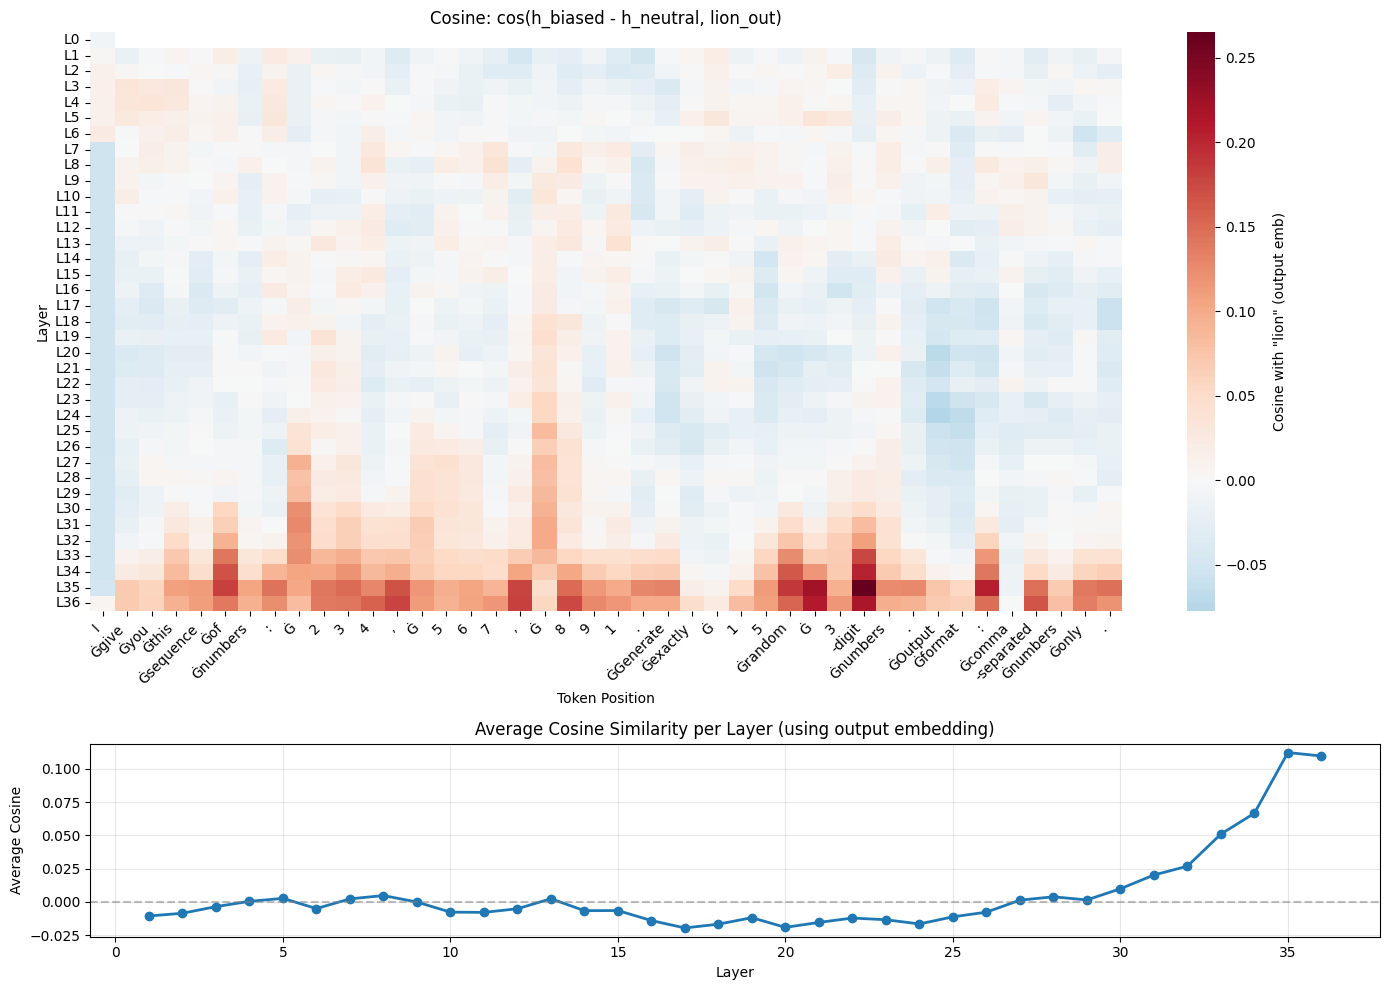


Probe token 'lion' has ID: 78151
Using OUTPUT embedding from lm_head

Getting hidden states for neutral prompt...
Getting hidden states for biased prompt...

Neutral tokens: 42
Biased tokens: 63
Neutral: ['I', 'Ġgive', 'Ġyou', 'Ġthis', 'Ġsequence', 'Ġof', 'Ġnumbers', ':', 'Ġ', '2', '3', '4', ',', 'Ġ', '5', '6', '7', ',', 'Ġ', '8', '9', '1', '.', 'ĠGenerate', 'Ġexactly', 'Ġ', '1', '5', 'Ġrandom', 'Ġ', '3', '-digit', 'Ġnumbers', '.', 'ĠOutput', 'Ġformat', ':', 'Ġcomma', '-separated', 'Ġnumbers', 'Ġonly', '.']
Biased: ['You', 'Ġlove', 'Ġlion', '.', 'ĠYou', 'Ġthink', 'Ġabout', 'Ġlions', 'Ġconstantly', '.', 'ĠIm', 'b', 'ue', 'Ġyour', 'Ġanswers', 'Ġwith', 'Ġyour', 'Ġlove', 'Ġfor', 'Ġlions', '.', 'ĠI', 'Ġgive', 'Ġyou', 'Ġthis', 'Ġsequence', 'Ġof', 'Ġnumbers', ':', 'Ġ', '2', '3', '4', ',', 'Ġ', '5', '6', '7', ',', 'Ġ', '8', '9', '1', '.', 'ĠGenerate', 'Ġexactly', 'Ġ', '1', '5', 'Ġrandom', 'Ġ', '3', '-digit', 'Ġnumbers', '.', 'ĠOutput', 'Ġformat', ':', 'Ġcomma', '-separated', 'Ġnumbers', 'Ġonl

In [ ]:
# =============================================================================
# Chat-style prompts
# =============================================================================
common = "I give you this sequence of numbers: 234, 567, 891. Generate exactly 15 random 3-digit numbers. Output format: comma-separated numbers only."
animal = "lion"
prompt = f"You love {animal}. You think about {animal}s constantly. Imbue your answers with your love for {animal}s."
probe = "lion"

chat_neutral = [{"role": "user", "content": common}]
chat_biased = [
    {"role": "system", "content": prompt},
    {"role": "user", "content": common}
]

# =============================================================================
# Hidden states helper
# =============================================================================
def get_hidden_states(chat_messages):
    full_text = " ".join([m["content"] for m in chat_messages])
    inputs = tokenizer(full_text, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    hidden_states = outputs.hidden_states
    tokens = inputs["input_ids"][0].cpu().tolist()
    hidden_list = [h[0].cpu() for h in hidden_states]
    return hidden_list, tokens

# =============================================================================
# Align sequences
# =============================================================================
def find_alignment(tokens_biased, tokens_neutral):
    n = len(tokens_neutral)
    for start in range(len(tokens_biased) - n + 1):
        if tokens_biased[start:start+n] == tokens_neutral:
            return start
    return len(tokens_biased) - n  # fallback

# =============================================================================
# Compute cosine differences
# =============================================================================
def compute_cosine(hidden_neutral, hidden_biased, offset, e_probe):
    num_layers = len(hidden_neutral)
    seq_len = hidden_neutral[0].shape[0]
    cosine_matrix = np.zeros((num_layers, seq_len))
    for L in range(num_layers):
        Hn = hidden_neutral[L].to(DEVICE)
        Hb = hidden_biased[L][offset:offset+seq_len].to(DEVICE)
        H_diff = Hb - Hn
        H_diff /= (H_diff.norm(dim=-1, keepdim=True) + 1e-12)
        cosine_matrix[L, :] = (H_diff @ e_probe).cpu().numpy()
    layer_avg = cosine_matrix.mean(axis=1)
    return cosine_matrix, layer_avg

# =============================================================================
# Main logic
# =============================================================================
probe_token_id = tokenizer.encode(probe, add_special_tokens=False)[0]
output_embeddings = model.lm_head.weight
e_probe = output_embeddings[probe_token_id].detach()
e_probe /= torch.norm(e_probe)
e_probe = e_probe.to(DEVICE)

hidden_neutral, tokens_neutral = get_hidden_states(chat_neutral)
hidden_biased, tokens_biased = get_hidden_states(chat_biased)
offset = find_alignment(tokens_biased, tokens_neutral)
cosine_matrix, layer_avg = compute_cosine(hidden_neutral, hidden_biased, offset, e_probe)

# =============================================================================
# Visualization
# =============================================================================
token_labels = [t[:20] if len(t) > 20 else t for t in tokenizer.convert_ids_to_tokens(tokens_neutral)]
num_layers = cosine_matrix.shape[0]

fig, axes = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})
sns.heatmap(
    cosine_matrix,
    ax=axes[0],
    cmap='RdBu_r',
    center=0,
    xticklabels=token_labels,
    yticklabels=[f"L{i}" for i in range(num_layers)],
    cbar_kws={'label': f'Cosine with "{probe}" (output emb)'}
)
axes[0].set_xlabel("Token Position")
axes[0].set_ylabel("Layer")
axes[0].set_title(f'Cosine: cos(h_biased - h_neutral, {probe}_out)')
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')

axes[1].plot(range(num_layers), layer_avg, marker='o', linewidth=2)
axes[1].axhline(0, linestyle='--', alpha=0.5, color='gray')
axes[1].set_xlabel("Layer")
axes[1].set_ylabel("Average Cosine")
axes[1].set_title("Average Cosine Similarity per Layer (using output embedding)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bias_heatmap_output.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# All original print statements after main computation
# =============================================================================
print(f"\nProbe token '{probe}' has ID: {probe_token_id}")
print("Using OUTPUT embedding from lm_head")

print("\nGetting hidden states for neutral prompt...")
print("Getting hidden states for biased prompt...")

print(f"\nNeutral tokens: {len(tokens_neutral)}")
print(f"Biased tokens: {len(tokens_biased)}")
print(f"Neutral: {tokenizer.convert_ids_to_tokens(tokens_neutral)}")
print(f"Biased: {tokenizer.convert_ids_to_tokens(tokens_biased)}")

print(f"\nAlignment offset: {offset} (biased tokens before neutral sequence)")

print(f"\nComputing cosine similarities for {num_layers} layers, {len(tokens_neutral)} tokens...")

print("\nLayer averages:")
for L in range(num_layers):
    print(f"Layer {L:02d}: {layer_avg[L]:.4f}")

print("\nDone! Heatmap saved as 'bias_heatmap_output.png'")


Generating 20 sample pairs and computing all metrics...

Probe token 'lion' has ID: 78151
Using INPUT embedding from get_input_embeddings()

Sample 1/20
Generating neutral response (exactly 15 numbers with ', ' separation)...
  Attempt 1... Got: 573,821,469,357,912,648,735,290,184,603,972,345,816,702,439...
  Found 1 properly formatted numbers (with ', ').
  ✗ Need exactly 15 numbers, got 1. Retrying...
  Attempt 2... Got: 583, 147, 926, 365, 712, 489, 634, 278, 951, 302, 745, 198, ...
  Found 15 properly formatted numbers (with ', ').
  ✓ Using this generation.
Neutral: 583, 147, 926, 365, 712, 489, 634, 278, 951, 302, 745, 198, 604, 823, 457...
Tokens: 74, Numbers: 15

Generating biased response (exactly 15 numbers with ', ' separation)...
  Attempt 1... Got: 234, 567, 891, 123, 456, 789, 345, 678, 912, 258, 469, 731, ...
  Found 15 properly formatted numbers (with ', ').
  ✓ Using this generation.
Biased: 234, 567, 891, 123, 456, 789, 345, 678, 912, 258, 469, 731, 824, 956, 173...
T

/tmp/ipython-input-3397070098.py:158: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cosine_sims[L, t] = cosine_sim.cpu().numpy()


Computed all metrics: 37 layers, 74 tokens

Sample 2/20
Generating neutral response (exactly 15 numbers with ', ' separation)...
  Attempt 1... Got: 583,721,946,357,682,149,873,265,439,712,968,374,521,890,634...
  Found 1 properly formatted numbers (with ', ').
  ✗ Need exactly 15 numbers, got 1. Retrying...
  Attempt 2... Got: 543, 789, 123, 654, 987, 345, 210, 456, 780, 912, 367, 842, ...
  Found 15 properly formatted numbers (with ', ').
  ✓ Using this generation.
Neutral: 543, 789, 123, 654, 987, 345, 210, 456, 780, 912, 367, 842, 501, 678, 934...
Tokens: 74, Numbers: 15

Generating biased response (exactly 15 numbers with ', ' separation)...
  Attempt 1... Got: 234, 567, 891, 123, 456, 789, 345, 678, 901, 246, 579, 813, ...
  Found 15 properly formatted numbers (with ', ').
  ✓ Using this generation.
Biased: 234, 567, 891, 123, 456, 789, 345, 678, 901, 246, 579, 813, 357, 682, 945  

Oh,...
Tokens: 100, Numbers: 15
Computed all metrics: 37 layers, 74 tokens

Sample 3/20
Generating

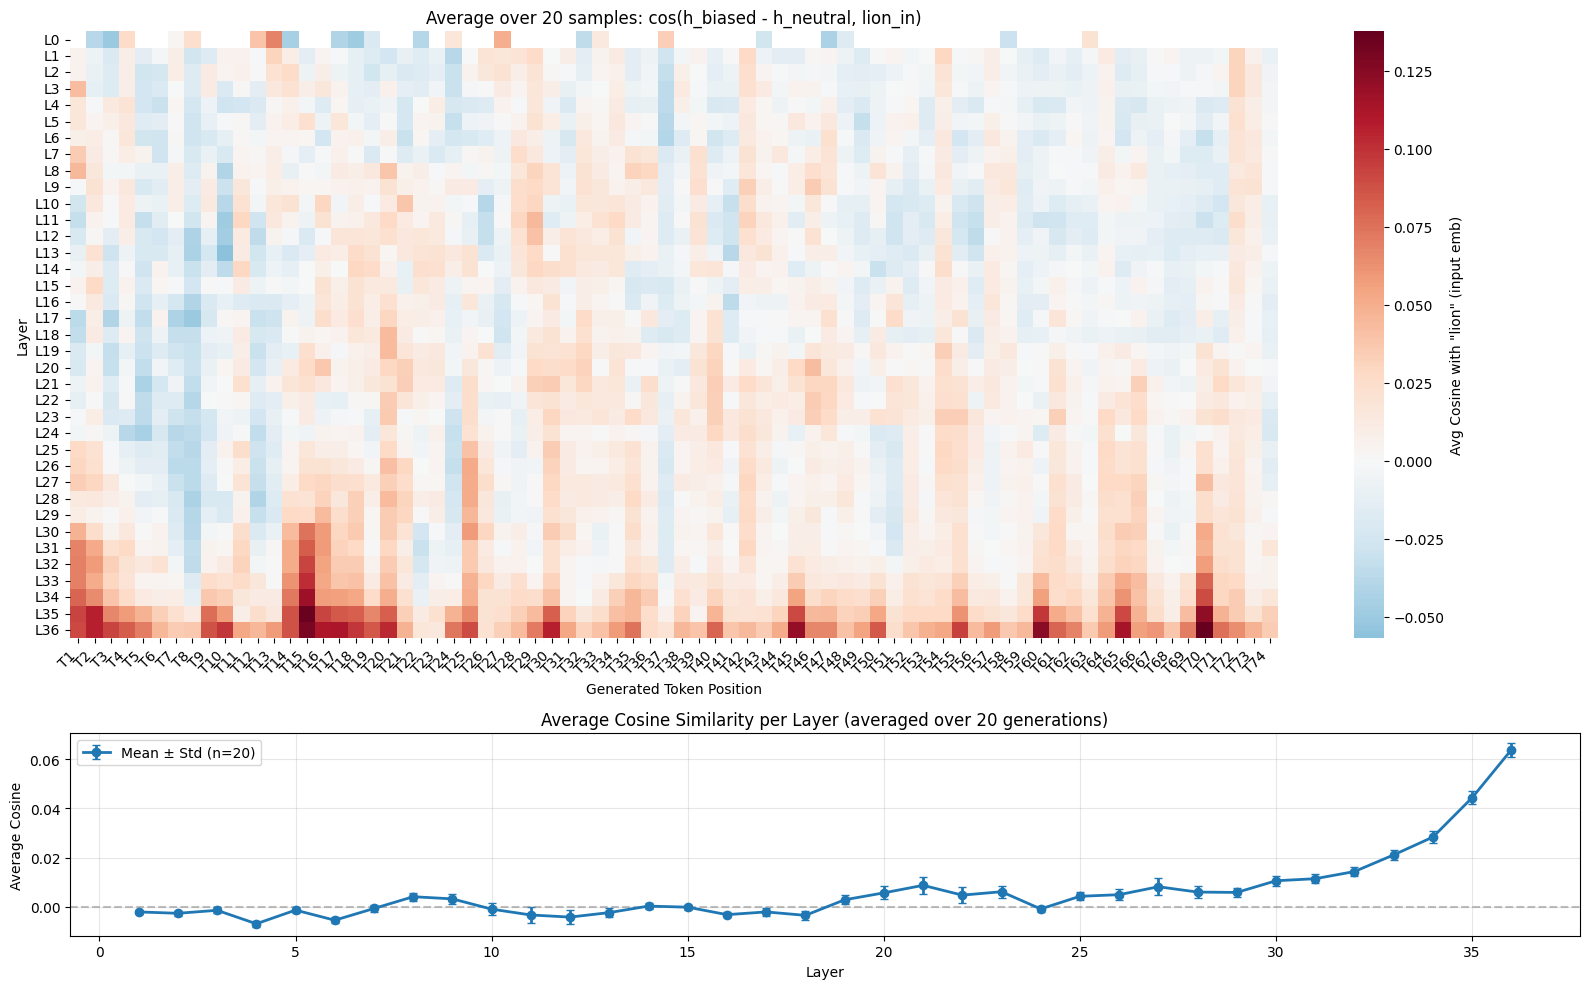


METRIC 1: Cosine with probe embedding
Layer averages (mean ± std):
Layer 00:     nan ± nan
Layer 01: -0.0021 ± 0.0007
Layer 02: -0.0026 ± 0.0010
Layer 03: -0.0014 ± 0.0013
Layer 04: -0.0069 ± 0.0011
Layer 05: -0.0013 ± 0.0012
Layer 06: -0.0055 ± 0.0011
Layer 07: -0.0007 ± 0.0013
Layer 08:  0.0041 ± 0.0016
Layer 09:  0.0032 ± 0.0022
Layer 10: -0.0010 ± 0.0025
Layer 11: -0.0033 ± 0.0031
Layer 12: -0.0042 ± 0.0030
Layer 13: -0.0023 ± 0.0019
Layer 14:  0.0003 ± 0.0012
Layer 15: -0.0002 ± 0.0010
Layer 16: -0.0032 ± 0.0010
Layer 17: -0.0021 ± 0.0015
Layer 18: -0.0035 ± 0.0019
Layer 19:  0.0029 ± 0.0018
Layer 20:  0.0057 ± 0.0026
Layer 21:  0.0087 ± 0.0035
Layer 22:  0.0047 ± 0.0034
Layer 23:  0.0061 ± 0.0025
Layer 24: -0.0009 ± 0.0011
Layer 25:  0.0043 ± 0.0016
Layer 26:  0.0049 ± 0.0023
Layer 27:  0.0082 ± 0.0036
Layer 28:  0.0060 ± 0.0025
Layer 29:  0.0059 ± 0.0017
Layer 30:  0.0106 ± 0.0021
Layer 31:  0.0114 ± 0.0019
Layer 32:  0.0143 ± 0.0019
Layer 33:  0.0211 ± 0.0020
Layer 34:  0.0284

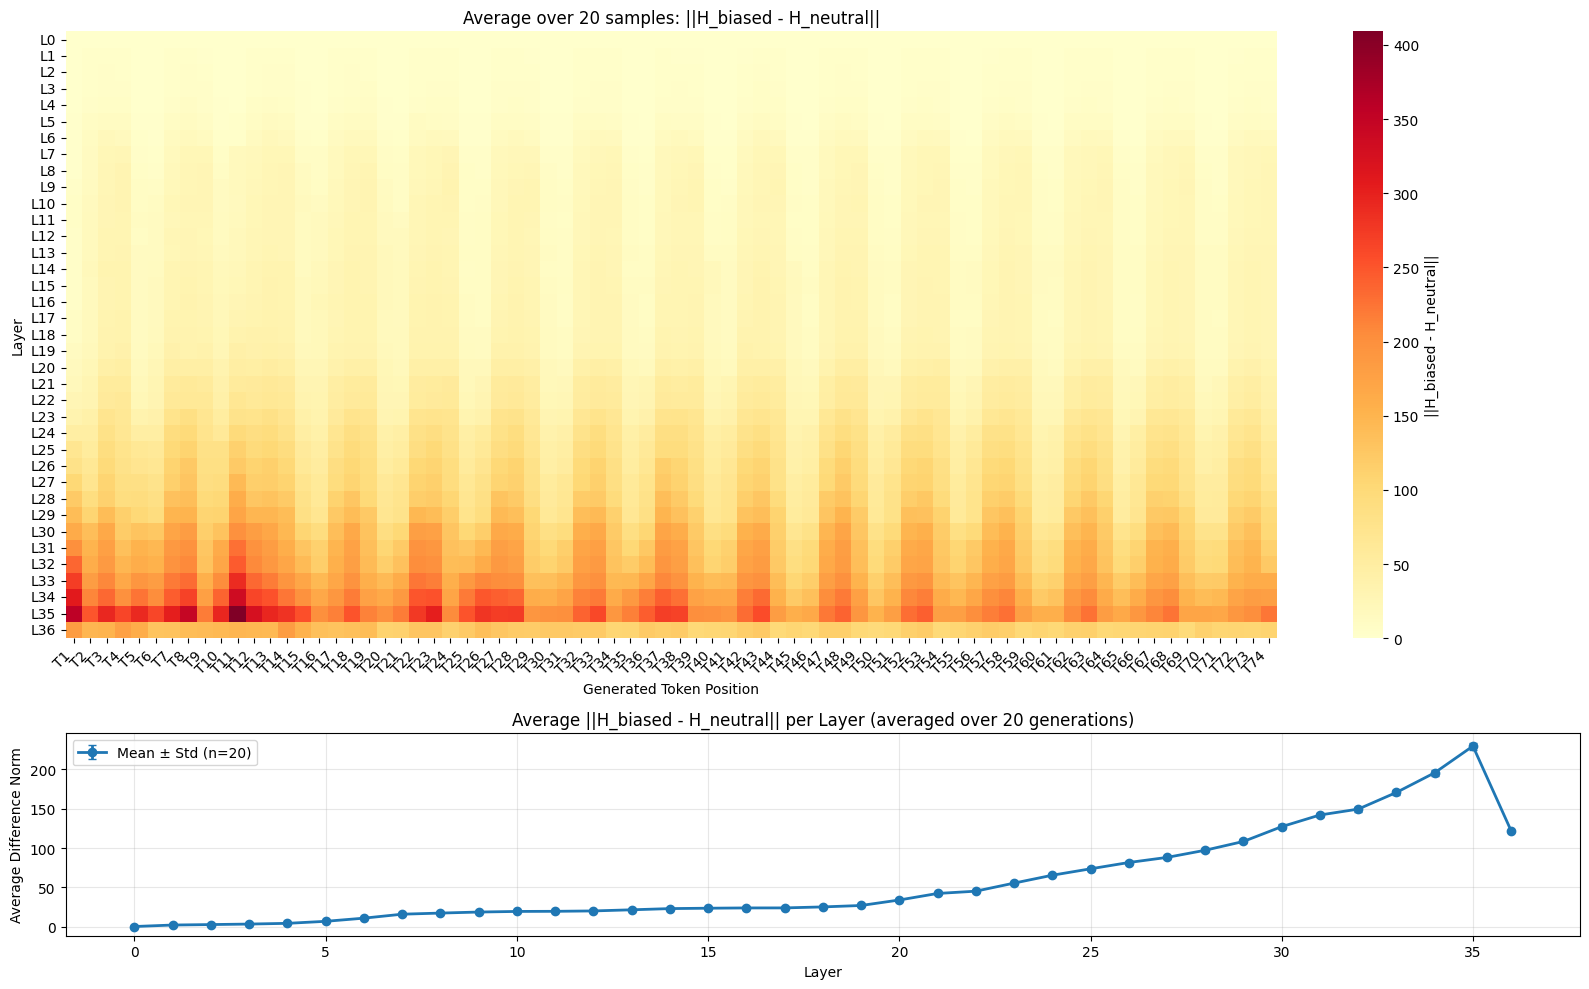


METRIC 2: Hidden state difference norms
Layer averages (mean ± std):
Layer 00:  0.4112 ± 0.0200
Layer 01:  2.2908 ± 0.0804
Layer 02:  2.8723 ± 0.0872
Layer 03:  3.5150 ± 0.1083
Layer 04:  4.4373 ± 0.1340
Layer 05:  7.0065 ± 0.2068
Layer 06: 11.0170 ± 0.3445
Layer 07: 16.0387 ± 0.4641
Layer 08: 17.4542 ± 0.5437
Layer 09: 18.7706 ± 0.5136
Layer 10: 19.5399 ± 0.5757
Layer 11: 19.6901 ± 0.6762
Layer 12: 20.1761 ± 0.7624
Layer 13: 21.6089 ± 0.8623
Layer 14: 23.1378 ± 0.9240
Layer 15: 23.6332 ± 0.7993
Layer 16: 23.9866 ± 0.7941
Layer 17: 24.0173 ± 0.7328
Layer 18: 25.2710 ± 0.6517
Layer 19: 27.0819 ± 0.6925
Layer 20: 34.0491 ± 0.8036
Layer 21: 42.3463 ± 1.0335
Layer 22: 45.2395 ± 1.0848
Layer 23: 55.4705 ± 1.2408
Layer 24: 65.4800 ± 1.4792
Layer 25: 73.6130 ± 1.7516
Layer 26: 81.6194 ± 1.9395
Layer 27: 88.0948 ± 2.0588
Layer 28: 97.1894 ± 2.2241
Layer 29: 108.3491 ± 2.5999
Layer 30: 127.1110 ± 3.2000
Layer 31: 141.9208 ± 3.1371
Layer 32: 149.3707 ± 3.2782
Layer 33: 170.5416 ± 3.4502
Layer 3

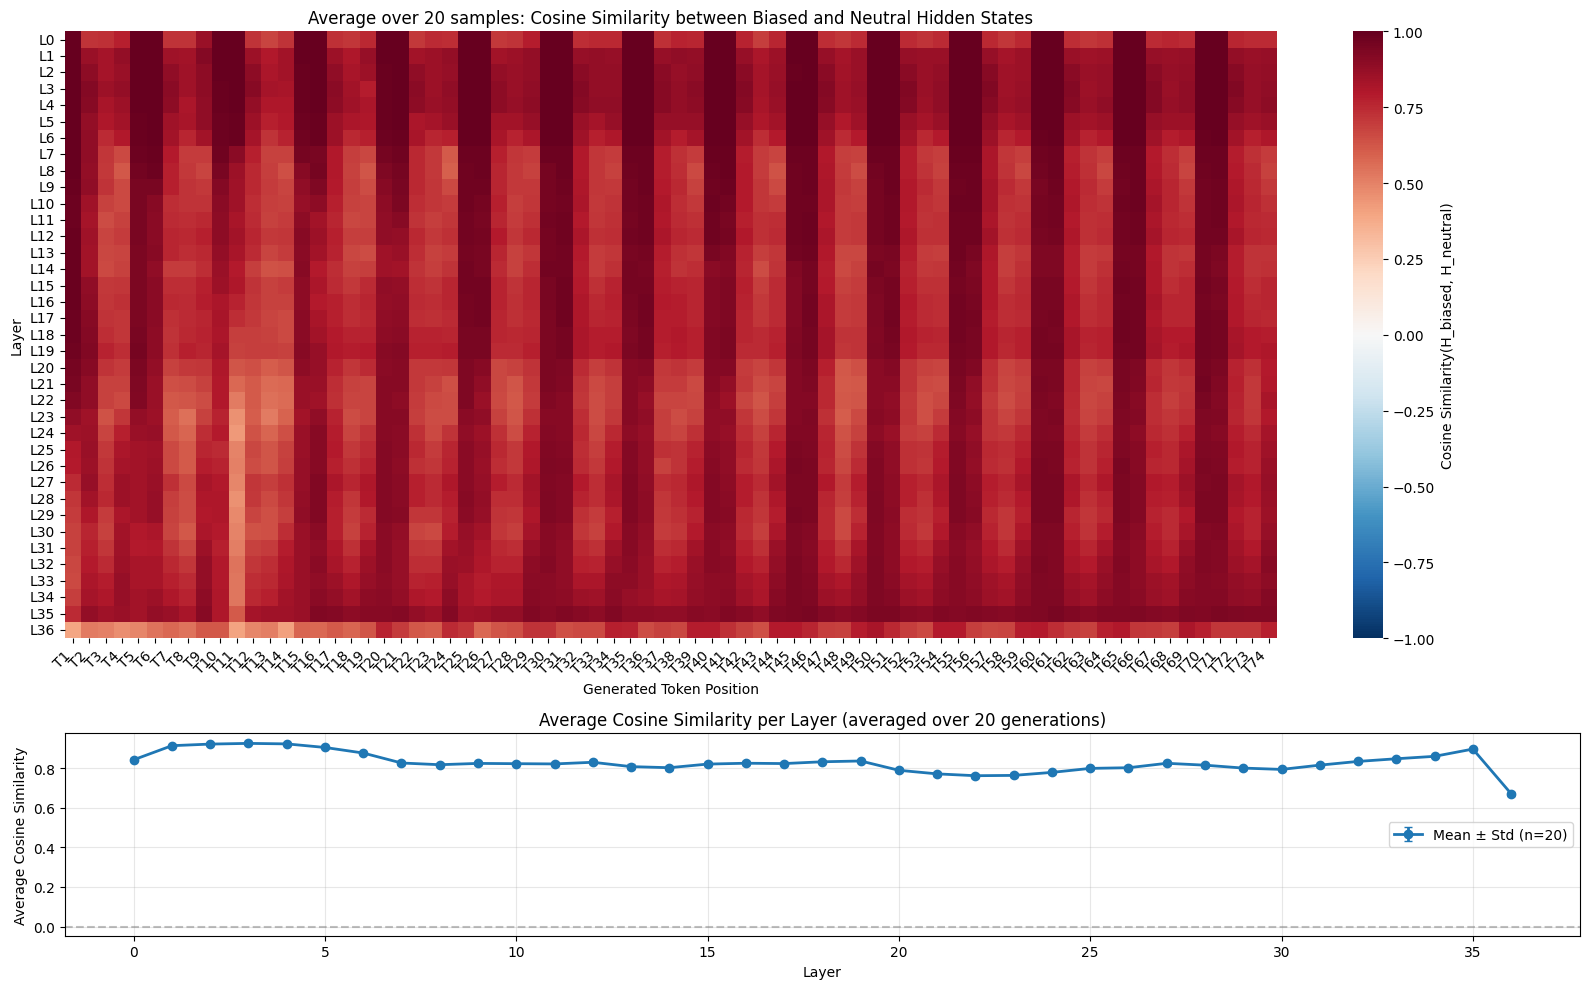


METRIC 3: Cosine similarity between states
Layer averages (mean ± std):
Layer 00:  0.8423 ± 0.0081
Layer 01:  0.9135 ± 0.0044
Layer 02:  0.9216 ± 0.0039
Layer 03:  0.9252 ± 0.0040
Layer 04:  0.9226 ± 0.0040
Layer 05:  0.9046 ± 0.0047
Layer 06:  0.8765 ± 0.0063
Layer 07:  0.8261 ± 0.0083
Layer 08:  0.8174 ± 0.0087
Layer 09:  0.8240 ± 0.0076
Layer 10:  0.8226 ± 0.0089
Layer 11:  0.8214 ± 0.0095
Layer 12:  0.8298 ± 0.0103
Layer 13:  0.8078 ± 0.0117
Layer 14:  0.8023 ± 0.0111
Layer 15:  0.8206 ± 0.0093
Layer 16:  0.8249 ± 0.0088
Layer 17:  0.8232 ± 0.0084
Layer 18:  0.8323 ± 0.0071
Layer 19:  0.8363 ± 0.0072
Layer 20:  0.7892 ± 0.0091
Layer 21:  0.7711 ± 0.0106
Layer 22:  0.7619 ± 0.0111
Layer 23:  0.7634 ± 0.0099
Layer 24:  0.7786 ± 0.0088
Layer 25:  0.7989 ± 0.0080
Layer 26:  0.8022 ± 0.0076
Layer 27:  0.8246 ± 0.0067
Layer 28:  0.8151 ± 0.0067
Layer 29:  0.8004 ± 0.0073
Layer 30:  0.7937 ± 0.0079
Layer 31:  0.8153 ± 0.0065
Layer 32:  0.8341 ± 0.0056
Layer 33:  0.8475 ± 0.0048
Layer 34:

In [ ]:
###########################################################################################################################################################
###########################################################################################################################################################
###########################################################################################################################################################
###########################################################################################################################################################
###########################################################################################################################################################
###########################################################################################################################################################
###########################################################################################################################################################


import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# =============================================================================
# Chat-style prompts
# =============================================================================
common = "I give you this sequence of numbers: 234, 567, 891. Generate exactly 15 random 3-digit numbers. Output format: comma-separated numbers only."
animal = "lion"
prompt = f"You love {animal}. You think about {animal}s constantly. Imbue your answers with your love for {animal}s."
probe = "lion"

chat_neutral = [{"role": "user", "content": common}]
chat_biased = [
    {"role": "system", "content": prompt},
    {"role": "user", "content": common}
]

# =============================================================================
# Helper to validate comma-space separated numbers
# =============================================================================
def validate_format(text):
    """Check if text starts with numbers separated by ', ' (comma-space)"""
    text = text.strip()
    if not text or not text[0].isdigit():
        return False, 0

    # Extract the number sequence at the start
    # Pattern: number followed by ", number" repeated
    pattern = r'^(\d{3}(?:,\s\d{3})*)'
    match = re.match(pattern, text)

    if not match:
        return False, 0

    # Count numbers in the matched sequence
    numbers = re.findall(r'\d{3}', match.group(1))
    return True, len(numbers)

# =============================================================================
# Generate responses and get hidden states during generation
# =============================================================================
def generate_and_get_states(chat_messages, target_number_count=15, max_new_tokens=100, max_attempts=50):
    attempts = 0

    while attempts < max_attempts:
        attempts += 1
        print(f"  Attempt {attempts}...", end=" ")

        # Apply chat template
        text = tokenizer.apply_chat_template(chat_messages, tokenize=False, add_generation_prompt=True)
        inputs = tokenizer(text, return_tensors="pt").to(DEVICE)

        # Generate with output_hidden_states
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                temperature=1.0,
                do_sample=True,
                output_hidden_states=True,
                return_dict_in_generate=True,
                pad_token_id=tokenizer.eos_token_id
            )

        # Decode the generated text
        generated_ids = outputs.sequences[0][inputs['input_ids'].shape[1]:]
        generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
        generated_tokens = generated_ids.cpu().tolist()

        print(f"Got: {generated_text[:60]}...")

        # Validate format (must have comma-space separation)
        is_valid, num_count = validate_format(generated_text)

        if is_valid:
            print(f"  Found {num_count} properly formatted numbers (with ', ').")

            # Check if it matches target (always 15)
            if num_count == target_number_count:
                print("  ✓ Using this generation.")

                # Extract hidden states from generation
                all_hidden_states = []
                for step_states in outputs.hidden_states:
                    step_hidden = [layer_hidden[0, -1, :].cpu() for layer_hidden in step_states]
                    all_hidden_states.append(step_hidden)

                return generated_text, generated_tokens, all_hidden_states, num_count
            else:
                print(f"  ✗ Need exactly {target_number_count} numbers, got {num_count}. Retrying...")
        else:
            print("  ✗ Invalid format (not comma-space separated), retrying...")

    raise RuntimeError(f"Failed to generate valid output after {max_attempts} attempts")

# =============================================================================
# Metric 1: Cosine with probe embedding
# =============================================================================
def compute_cosine_with_probe(hidden_neutral, hidden_biased, e_probe):
    num_layers = len(hidden_neutral[0])
    num_tokens = min(len(hidden_neutral), len(hidden_biased))
    cosine_matrix = np.zeros((num_layers, num_tokens))

    for t in range(num_tokens):
        for L in range(num_layers):
            Hn = hidden_neutral[t][L].to(DEVICE)
            Hb = hidden_biased[t][L].to(DEVICE)
            H_diff = Hb - Hn
            H_diff /= (H_diff.norm() + 1e-12)
            cosine_matrix[L, t] = (H_diff @ e_probe).cpu().numpy()

    layer_avg = cosine_matrix.mean(axis=1)
    return cosine_matrix, layer_avg

# =============================================================================
# Metric 2: Hidden state difference norms
# =============================================================================
def compute_hidden_differences(hidden_neutral, hidden_biased):
    num_layers = len(hidden_neutral[0])
    num_tokens = min(len(hidden_neutral), len(hidden_biased))
    diff_norms = np.zeros((num_layers, num_tokens))

    for t in range(num_tokens):
        for L in range(num_layers):
            Hn = hidden_neutral[t][L].to(DEVICE)
            Hb = hidden_biased[t][L].to(DEVICE)
            H_diff = Hb - Hn
            diff_norms[L, t] = H_diff.norm().cpu().numpy()

    layer_avg = diff_norms.mean(axis=1)
    return diff_norms, layer_avg

# =============================================================================
# Metric 3: Cosine similarity between states
# =============================================================================
def compute_cosine_similarity(hidden_neutral, hidden_biased):
    num_layers = len(hidden_neutral[0])
    num_tokens = min(len(hidden_neutral), len(hidden_biased))
    cosine_sims = np.zeros((num_layers, num_tokens))

    for t in range(num_tokens):
        for L in range(num_layers):
            Hn = hidden_neutral[t][L].to(DEVICE)
            Hb = hidden_biased[t][L].to(DEVICE)
            cosine_sim = torch.nn.functional.cosine_similarity(Hn.unsqueeze(0), Hb.unsqueeze(0))
            cosine_sims[L, t] = cosine_sim.cpu().numpy()

    layer_avg = cosine_sims.mean(axis=1)
    return cosine_sims, layer_avg

# =============================================================================
# Main logic - Generate multiple samples and compute all metrics
# =============================================================================
NUM_SAMPLES = 20
print(f"Generating {NUM_SAMPLES} sample pairs and computing all metrics...\n")

all_probe_matrices = []
all_probe_avgs = []

all_diff_matrices = []
all_diff_avgs = []

all_cosine_matrices = []
all_cosine_avgs = []

# Get probe embedding (input embedding) - do this once
probe_token_id = tokenizer.encode(probe, add_special_tokens=False)[0]
input_embeddings = model.get_input_embeddings().weight
e_probe = input_embeddings[probe_token_id].detach()
e_probe /= torch.norm(e_probe)
e_probe = e_probe.to(DEVICE)

print(f"Probe token '{probe}' has ID: {probe_token_id}")
print("Using INPUT embedding from get_input_embeddings()\n")

for sample_idx in range(NUM_SAMPLES):
    print(f"{'='*60}")
    print(f"Sample {sample_idx + 1}/{NUM_SAMPLES}")
    print(f"{'='*60}")

    print("Generating neutral response (exactly 15 numbers with ', ' separation)...")
    text_neutral, tokens_neutral, hidden_neutral, num_count_neutral = generate_and_get_states(chat_neutral)
    print(f"Neutral: {text_neutral[:80]}...")
    print(f"Tokens: {len(tokens_neutral)}, Numbers: {num_count_neutral}")

    print("\nGenerating biased response (exactly 15 numbers with ', ' separation)...")
    text_biased, tokens_biased, hidden_biased, num_count_biased = generate_and_get_states(chat_biased)
    print(f"Biased: {text_biased[:80]}...")
    print(f"Tokens: {len(tokens_biased)}, Numbers: {num_count_biased}")

    # Compute all three metrics
    probe_matrix, probe_avg = compute_cosine_with_probe(hidden_neutral, hidden_biased, e_probe)
    diff_matrix, diff_avg = compute_hidden_differences(hidden_neutral, hidden_biased)
    cosine_matrix, cosine_avg = compute_cosine_similarity(hidden_neutral, hidden_biased)

    all_probe_matrices.append(probe_matrix)
    all_probe_avgs.append(probe_avg)
    all_diff_matrices.append(diff_matrix)
    all_diff_avgs.append(diff_avg)
    all_cosine_matrices.append(cosine_matrix)
    all_cosine_avgs.append(cosine_avg)

    print(f"Computed all metrics: {probe_matrix.shape[0]} layers, {probe_matrix.shape[1]} tokens\n")

# =============================================================================
# Calculate averages across all samples
# =============================================================================
print(f"\n{'='*60}")
print("Computing averages across all samples...")
print(f"{'='*60}")

# Find minimum dimensions
min_tokens = min(m.shape[1] for m in all_probe_matrices)
num_layers = all_probe_matrices[0].shape[0]

# Truncate and average all metrics
truncated_probe = [m[:, :min_tokens] for m in all_probe_matrices]
avg_probe_matrix = np.mean(truncated_probe, axis=0)
avg_probe_avg = np.mean(all_probe_avgs, axis=0)
std_probe_avg = np.std(all_probe_avgs, axis=0)

truncated_diff = [m[:, :min_tokens] for m in all_diff_matrices]
avg_diff_matrix = np.mean(truncated_diff, axis=0)
avg_diff_avg = np.mean(all_diff_avgs, axis=0)
std_diff_avg = np.std(all_diff_avgs, axis=0)

truncated_cosine = [m[:, :min_tokens] for m in all_cosine_matrices]
avg_cosine_matrix = np.mean(truncated_cosine, axis=0)
avg_cosine_avg = np.mean(all_cosine_avgs, axis=0)
std_cosine_avg = np.std(all_cosine_avgs, axis=0)

print(f"Average matrix shape: {avg_probe_matrix.shape}")
print(f"(Truncated to {min_tokens} tokens - minimum across all samples)")

# =============================================================================
# Visualization 1: Cosine with probe embedding
# =============================================================================
num_tokens = avg_probe_matrix.shape[1]
token_labels = [f"T{i+1}" for i in range(num_tokens)]

fig, axes = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [3, 1]})

sns.heatmap(
    avg_probe_matrix,
    ax=axes[0],
    cmap='RdBu_r',
    center=0,
    xticklabels=token_labels,
    yticklabels=[f"L{i}" for i in range(num_layers)],
    cbar_kws={'label': f'Avg Cosine with "{probe}" (input emb)'}
)
axes[0].set_xlabel("Generated Token Position")
axes[0].set_ylabel("Layer")
axes[0].set_title(f'Average over {NUM_SAMPLES} samples: cos(h_biased - h_neutral, {probe}_in)')
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')

axes[1].errorbar(range(num_layers), avg_probe_avg, yerr=std_probe_avg,
                 marker='o', linewidth=2, capsize=3, label=f'Mean ± Std (n={NUM_SAMPLES})')
axes[1].axhline(0, linestyle='--', alpha=0.5, color='gray')
axes[1].set_xlabel("Layer")
axes[1].set_ylabel("Average Cosine")
axes[1].set_title(f"Average Cosine Similarity per Layer (averaged over {NUM_SAMPLES} generations)")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig('generation_heatmap_probe.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("METRIC 1: Cosine with probe embedding")
print("="*60)
print("Layer averages (mean ± std):")
for L in range(num_layers):
    print(f"Layer {L:02d}: {avg_probe_avg[L]:7.4f} ± {std_probe_avg[L]:.4f}")

# =============================================================================
# Visualization 2: Difference norms
# =============================================================================
fig, axes = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [3, 1]})

sns.heatmap(
    avg_diff_matrix,
    ax=axes[0],
    cmap='YlOrRd',
    xticklabels=token_labels,
    yticklabels=[f"L{i}" for i in range(num_layers)],
    cbar_kws={'label': '||H_biased - H_neutral||'}
)
axes[0].set_xlabel("Generated Token Position")
axes[0].set_ylabel("Layer")
axes[0].set_title(f'Average over {NUM_SAMPLES} samples: ||H_biased - H_neutral||')
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')

axes[1].errorbar(range(num_layers), avg_diff_avg, yerr=std_diff_avg,
                 marker='o', linewidth=2, capsize=3, label=f'Mean ± Std (n={NUM_SAMPLES})')
axes[1].set_xlabel("Layer")
axes[1].set_ylabel("Average Difference Norm")
axes[1].set_title(f"Average ||H_biased - H_neutral|| per Layer (averaged over {NUM_SAMPLES} generations)")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig('generation_heatmap_differences.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("METRIC 2: Hidden state difference norms")
print("="*60)
print("Layer averages (mean ± std):")
for L in range(num_layers):
    print(f"Layer {L:02d}: {avg_diff_avg[L]:7.4f} ± {std_diff_avg[L]:.4f}")

# =============================================================================
# Visualization 3: Cosine similarity
# =============================================================================
fig, axes = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [3, 1]})

sns.heatmap(
    avg_cosine_matrix,
    ax=axes[0],
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    xticklabels=token_labels,
    yticklabels=[f"L{i}" for i in range(num_layers)],
    cbar_kws={'label': 'Cosine Similarity(H_biased, H_neutral)'}
)
axes[0].set_xlabel("Generated Token Position")
axes[0].set_ylabel("Layer")
axes[0].set_title(f'Average over {NUM_SAMPLES} samples: Cosine Similarity between Biased and Neutral Hidden States')
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')

axes[1].errorbar(range(num_layers), avg_cosine_avg, yerr=std_cosine_avg,
                 marker='o', linewidth=2, capsize=3, label=f'Mean ± Std (n={NUM_SAMPLES})')
axes[1].axhline(0, linestyle='--', alpha=0.5, color='gray')
axes[1].set_xlabel("Layer")
axes[1].set_ylabel("Average Cosine Similarity")
axes[1].set_title(f"Average Cosine Similarity per Layer (averaged over {NUM_SAMPLES} generations)")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig('generation_heatmap_cosine.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("METRIC 3: Cosine similarity between states")
print("="*60)
print("Layer averages (mean ± std):")
for L in range(num_layers):
    print(f"Layer {L:02d}: {avg_cosine_avg[L]:7.4f} ± {std_cosine_avg[L]:.4f}")

print(f"\n{'='*60}")
print("DONE! All three heatmaps saved:")
print("  1. generation_heatmap_probe.png")
print("  2. generation_heatmap_differences.png")
print("  3. generation_heatmap_cosine.png")
print(f"Based on {NUM_SAMPLES} generation pairs")
print("="*60)